# Run seismic analysis of a nonlinear frame building

Warning: This script should only be run from start to finish, rerunning particular cells tries to initiate new objects in openseespy which causes a problem with the tags.

### Load inline plotting and auto-reload commands

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('..')  # set working directory to project directory


In [3]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import sfsimodels
import eqsig

import numpy as np

from openseespy import opensees as opy
import openseespy.wrap.static as opc
import openseespy.wrap as opw


### Define the building

In [4]:
number_of_storeys = 1
fb = sfsimodels.FrameBuilding2D(number_of_storeys, n_bays=1)
fb.interstorey_heights = 3.4 * np.ones(number_of_storeys)
fb.floor_length = 18.0  # m
fb.floor_width = 16.0  # m
fb.storey_masses = 40.0e3 * np.ones(number_of_storeys)  # kg

fb.bay_lengths = [6.]
fb.set_beam_prop("depth", [0.5], repeat="up")
fb.set_beam_prop("width", [0.4], repeat="up")
fb.set_column_prop("width", [0.5, 0.5], repeat="up")
fb.set_column_prop("depth", [0.5, 0.5], repeat="up")


### Define ground motion

In [5]:
from tests import conftest
record_filename = 'test_motion_dt0p01.txt'
motion_step = 0.01
rec = np.loadtxt(conftest.TEST_DATA_DIR + record_filename)
asig = eqsig.AccSignal(rec, motion_step)

### Establish an Opensees instance and define additional variables

In [6]:
osi = opw.OpenseesInstance(dimensions=2)

q_floor = 10000.  # kPa
trib_width = fb.floor_length
trib_mass_per_length = q_floor * trib_width / 9.8


### Establish nodes and set mass based on trib area

Nodes named as: C<column-number>-S<storey-number>, first column starts at C1-S0 = ground level left

In [7]:
nd = OrderedDict()
col_xs = np.cumsum(fb.bay_lengths)
col_xs = np.insert(col_xs, 0, 0)
n_cols = len(col_xs)
sto_ys = fb.heights
sto_ys = np.insert(sto_ys, 0, 0)
for cc in range(1, n_cols + 1):
    for ss in range(fb.n_storeys + 1):
        nd["C{0}-S{1}".format(cc, ss)] = opw.nodes.Node(osi, col_xs[cc - 1], sto_ys[ss])

        if ss != 0:
            if cc == 1:
                node_mass = trib_mass_per_length * fb.bay_lengths[0] / 2
            elif cc == n_cols:
                node_mass = trib_mass_per_length * fb.bay_lengths[-1] / 2
            else:
                node_mass = trib_mass_per_length * (fb.bay_lengths[cc - 2] + fb.bay_lengths[cc - 1] / 2)
            opw.set_node_mass(nd["C{0}-S{1}".format(cc, ss)], node_mass, 0., 0.)


### Set all nodes on a storey to have the same displacement and fix base nodes

In [8]:
for ss in range(0, fb.n_storeys + 1):
    for cc in range(1, n_cols + 1):
        opw.set_equal_dofs(nd["C{0}-S{1}".format(1, ss)], nd["C{0}-S{1}".format(cc, ss)], opc.X)

# Fix all base nodes
for cc in range(1, n_cols + 1):
    opy.fix(nd["C%i-S%i" % (cc, 0)].tag, opc.FIXED, opc.FIXED, opc.FIXED)

# Coordinate transformation
transf = opw.transformations.Linear(osi, [])



### Define beams and columns
 - Columns named as: C<column-number>-S<storey-number>, first column starts at C1-S0 = ground floor left
 - Beams named as: B<bay-number>-S<storey-number>, first beam starts at B1-S1 = first storey left (foundation at S0)


In [9]:
l_hinge = fb.bay_lengths[0] * 0.1

# Define material
e_conc = 30.0e6
i_beams = 0.4 * fb.beam_widths * fb.beam_depths ** 3 / 12
i_columns = 0.5 * fb.column_widths * fb.column_depths ** 3 / 12
a_beams = fb.beam_widths * fb.beam_depths
a_columns = fb.column_widths * fb.column_depths
ei_beams = e_conc * i_beams
ei_columns = e_conc * i_columns
eps_yield = 300.0e6 / 200e9
phi_y_col = 2.1 * eps_yield / fb.column_depths
phi_y_beam = 2.1 * eps_yield / fb.beam_depths * 10  # TODO: re-evaluate

md = OrderedDict()  # material dict
sd = OrderedDict()  # section dict
ed = OrderedDict()  # element dict

for ss in range(fb.n_storeys):

    # set columns
    for cc in range(1, fb.n_cols + 1):
        lp_i = 0.4
        lp_j = 0.4  # plastic hinge length
        ele_str = "C{0}-S{1}S{2}".format(cc, ss, ss + 1)

        top_sect = opw.sections.Elastic(osi, e_conc, a_columns[ss][cc - 1], i_columns[ss][cc - 1])
        bot_sect = opw.sections.Elastic(osi, e_conc, a_columns[ss][cc - 1], i_columns[ss][cc - 1])
        centre_sect = opw.sections.Elastic(osi, e_conc, a_columns[ss][cc - 1], i_columns[ss][cc - 1])
        sd[ele_str + "T"] = top_sect
        sd[ele_str + "B"] = bot_sect
        sd[ele_str + "C"] = centre_sect

        integ = opw.beam_integrations.HingeMidpoint(osi, bot_sect, lp_i, top_sect, lp_j, centre_sect)

        left_node = nd["C%i-S%i" % (cc, ss)]
        right_node = nd["C%i-S%i" % (cc, ss + 1)]
        ed[ele_str] = opw.elements.ForceBeamColumn(osi, left_node, right_node, transf, integ)

    # Set beams
    for bb in range(1, fb.n_bays + 1):
        lp_i = 0.5
        lp_j = 0.5
        ele_str = "C{0}C{1}-S{2}".format(bb - 1, bb, ss)

        mat = opw.uniaxial_materials.ElasticBiLinear(osi, ei_beams[ss][bb - 1], 0.05 * ei_beams[ss][bb - 1], phi_y_beam[ss][bb - 1])
        md[ele_str] = mat
        left_sect = opw.sections.Uniaxial(osi, mat, quantity=opc.M_Z)
        right_sect = opw.sections.Uniaxial(osi, mat, quantity=opc.M_Z)
        centre_sect = opw.sections.Elastic(osi, e_conc, a_beams[ss][bb - 1], i_beams[ss][bb - 1])
        integ = opw.beam_integrations.HingeMidpoint(osi, left_sect, lp_i, right_sect, lp_j, centre_sect)

        left_node = nd["C%i-S%i" % (bb, ss + 1)]
        right_node = nd["C%i-S%i" % (bb + 1, ss + 1)]
        ed[ele_str] = opw.elements.ForceBeamColumn(osi, left_node, right_node, transf, integ)


### Define the dynamic analysis

In [10]:
load_tag_dynamic = 1
pattern_tag_dynamic = 1

values = list(-1 * asig.values)  # should be negative
opy.timeSeries('Path', load_tag_dynamic, '-dt', asig.dt, '-values', *values)
opy.pattern('UniformExcitation', pattern_tag_dynamic, opc.X, '-accel', load_tag_dynamic)

# set damping based on first eigen mode
angular_freq = opy.eigen('-fullGenLapack', 1) ** 0.5
if isinstance(angular_freq, complex):
    raise ValueError("Angular frequency is complex, issue with stiffness or mass")
    
xi = 0.05
beta_k = 2 * xi / angular_freq
opw.rayleigh.Rayleigh(osi, alpha_m=0.0, beta_k=beta_k, beta_k_init=0.0, beta_k_comm=0.0)


### Run the dynamic analysis

In [11]:
opy.wipeAnalysis()

opw.algorithms.Newton(osi)
opy.system('SparseGeneral')
opy.numberer('RCM')
opy.constraints('Transformation')
opy.integrator('Newmark', 0.5, 0.25)
opy.analysis('Transient')
#op.test("NormDispIncr", 1.0e-1, 2, 0)
tol = 1.0e-4
iter = 4
opy.test('EnergyIncr', tol, iter, 0, 2)
extra_time = 10
analysis_dt = 0.001
analysis_time = (len(values) - 1) * asig.dt + extra_time
analysis_dt
outputs = {
    "time": [],
    "rel_disp": [],
    "rel_accel": [],
    "rel_vel": [],
    "force": [],
    "ele_mom": [],
    "ele_curve": [],
}
print("Analysis starting")
opy.recorder('Element', '-file', 'ele_out.txt', '-time', '-ele', 1, 'force')
while opy.getTime() < analysis_time:
    curr_time = opy.getTime()
    opy.analyze(1, analysis_dt)
    outputs["time"].append(curr_time)
    outputs["rel_disp"].append(opy.nodeDisp(nd["C%i-S%i" % (1, fb.n_storeys)].tag, opc.X))
    outputs["rel_vel"].append(opy.nodeVel(nd["C%i-S%i" % (1, fb.n_storeys)].tag, opc.X))
    outputs["rel_accel"].append(opy.nodeAccel(nd["C%i-S%i" % (1, fb.n_storeys)].tag, opc.X))
    # outputs['ele_mom'].append(opy.eleResponse('-ele', [ed['B%i-S%i' % (1, 0)], 'basicForce'])) # not working
    opy.reactions()
    react = 0
    for cc in range(1, fb.n_cols):
        react += -opy.nodeReaction(nd["C%i-S%i" % (cc, 0)].tag, opc.X)
    outputs["force"].append(react)  # Should be negative since diff node
opy.wipe()
for item in outputs:
    outputs[item] = np.array(outputs[item])
print('Analysis complete')

Analysis starting
Analysis complete


### Plot roof displacement

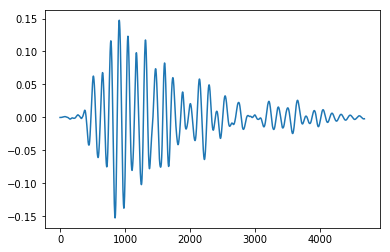

In [12]:
acc_opensees = np.interp(asig.time, outputs["time"], outputs["rel_accel"]) - rec
ux_opensees = np.interp(asig.time, outputs["time"], outputs["rel_disp"])
plt.plot(ux_opensees)